In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

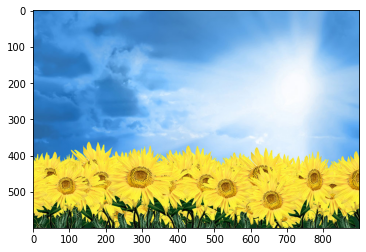

In [2]:
#img = plt.imread("zhyto.jpg")
#img = plt.imread("more.jpg")
#img = plt.imread("check.jpg")
#img = plt.imread("pole1.jpg")
#img = plt.imread("pole2.jpg")
img = plt.imread("pole3.jpg")
plt.imshow(img)

# 1) Оцінити параметри гаусівського розподілу для обох сегментів

In [3]:
height, width, channels = img.shape

segment0 = img[:height//10, :width//2,:]
segment1 = img[-height//10:, :width//2,:]

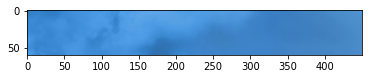

In [4]:
plt.imshow(segment0)

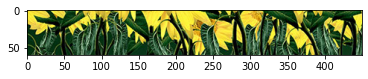

In [5]:
plt.imshow(segment1)

In [6]:
m0 = segment0.mean(axis = (0,1))
m1 = segment1.mean(axis = (0,1))

In [7]:
m0, m1

(array([ 66.85574074, 139.27277778, 208.57981481]),
 array([ 96.0477037 , 111.90522222,  44.05433333]))

In [8]:
cov0 = np.cov( segment0.reshape(-1,3), rowvar = False) 
cov1 = np.cov( segment1.reshape(-1,3) , rowvar = False) 

In [9]:
cov0, cov1

(array([[ 78.69406682,  84.7004137 ,  82.12531496],
        [ 84.7004137 , 119.11574472, 139.3014802 ],
        [ 82.12531496, 139.3014802 , 182.33830879]]),
 array([[9282.05468935, 7314.81418104, 2036.14593202],
        [7314.81418104, 6149.07079757, 1941.26641872],
        [2036.14593202, 1941.26641872, 1169.6204042 ]]))

# 2) Відповідно до оцінених параметрів, віднести кожен піксель до одного із сегментів.

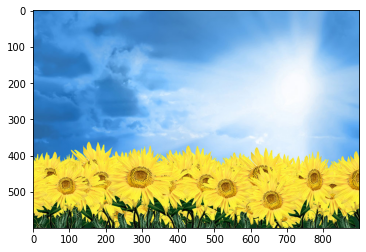

In [10]:
plt.imshow(img)

CPU times: user 617 ms, sys: 221 ms, total: 839 ms
Wall time: 553 ms


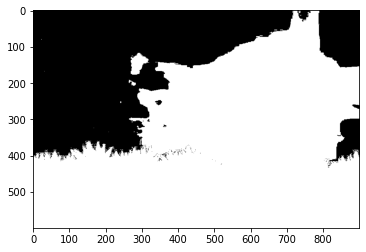

In [11]:
%%time
from scipy.stats import multivariate_normal as mv_normal
mask = (mv_normal.pdf(img,m1,cov1)>mv_normal.pdf(img,m0,cov0)).astype('int')
plt.imshow( mask, cmap='gray' )

# 3) Задати параметр eps - ймовірність знаходитись поруч для пікселів різних класів. Провести семплювання міток

In [12]:
eps = 0.1

In [13]:
os.system("rm -r iters")
os.mkdir("iters")

100%|██████████| 200/200 [01:15<00:00,  2.66it/s]

CPU times: user 1min 9s, sys: 5.3 s, total: 1min 15s
Wall time: 1min 15s


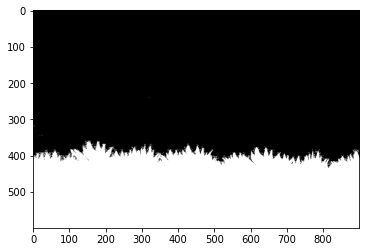

In [14]:
%%time
n_iter = 200

for j in tqdm(range(n_iter)):
    #проверяем сходство каждого пикселя с пикселем слева. Если слева пикселя нет, ставим единицу.
    mask_left = np.ones( mask.shape )
    mask_left[:,1:] = (mask[:,1:]==mask[:,:-1] )*(1-eps) + (mask[:,1:]!=mask[:,:-1])*(eps)
    
    #проверяем сходство каждого пикселя с пикселем справа. Если справа пикселя нет, ставим единицу.
    mask_right = np.ones( mask.shape )
    mask_right[:,:-1] = (mask[:,:-1]==mask[:,:1])*(1-eps) + (mask[:,:-1]!=mask[:,:1])*(eps)

    #проверяем сходство каждого пикселя с пикселем сверху. Если сверху пикселя нет, ставим единицу.
    mask_up = np.ones( mask.shape )
    mask_up[1:,:] = (mask[1:,:]==mask[:-1,:])*(1-eps) + (mask[1:,:]!=mask[:-1,:])*(eps)
    
    #проверяем сходство каждого пикселя с пикселем снизу. Если пикселя снизу нет, ставим единицу.
    mask_down = np.ones(mask.shape)
    mask_down[:-1, :] = (mask[:-1,:]==mask[1:,:])*(1-eps) + (mask[:-1,:]!=mask[1:,:])*(eps) 
    
    #Вычисляем матрицу вероятностей нулей и единиц для каждого пикселя 
    # (при условии собственного цвета, и известных меток соседей)
    p0_mat = mv_normal.pdf(img,m0,cov0)*mask_left*mask_right*mask_up*mask_down
    p1_mat = mv_normal.pdf(img,m1,cov1)*mask_left*mask_right*mask_up*mask_down
    
    s_mat = p0_mat+p1_mat
    p0_mat = p0_mat/s_mat
    p1_mat = p1_mat/s_mat
    
    #Переходим к генерации самих меток.
    #теперь для каждого пикселя имеем p(0/x), p(1/x)
    #Y ~ U[0,1] . Y>p(0/x) -> метка 1, Y<=p(0/x) -> метка 0.
    prob_mat = np.random.uniform(low=0.0, high = 1.0, size = mask.shape)
    mask = (prob_mat > p0_mat).astype('int')
    plt.imsave(fname = f"iters/iter{j}", arr=mask, cmap='gray', format='png' )
    
    pixels0 = img[mask==0]
    pixels1 = img[mask==1]
    
    #обновляем параметры гауссовского распределения
    m0 = pixels0.mean(axis = 0)
    m1 = pixels1.mean(axis = 0)
    
    cov0 = np.cov( pixels0, rowvar = False) 
    cov1 = np.cov( pixels1, rowvar = False) 
    
plt.imshow(p1_mat, cmap='gray')